In [ ]:
### langchain, ## may test use tool node and agent to check stock infor

In [74]:
from langchain import OpenAI, LLMMathChain, SerpAPIWrapper
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.tools import BaseTool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
import json, os
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

In [75]:
os.environ['OPENAI_API_KEY']=API_KEY
os.environ["TAVILY_API_KEY"]=Tav_API_KEY

In [76]:
### tavily search tool
from langchain_community.tools import TavilySearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(max_results=2)
search_tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Feb 14, 2024 ... Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Jun 26, 2024 ... Imagine your application as a directed graph. In LangGraph, each node represents an LLM agent, and the edges are the communication channels'}]

In [77]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620",
                    anthropic_api_key='')
# Modification: tell the LLM which tools it can call

from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(max_results=2)
search_tool.invoke("What's a 'node' in LangGraph?")


############################################################################################################
### test API case use my function, not depdent on lainchain library
import yfinance as yf
import pandas
import tvscreener as tvs
from tvscreener import StockField, TimeInterval
from tvscreener.filter import FilterOperator
################ New ######################################################################################


@tool
def get_stock_info(query: str) -> dict:
    """
    Fetches stock information for a given query.

    Args:
        query (str): The stock ticker or query to search for.

    Returns:
        dict: A dictionary containing stock information or error details.
    """
    try:
        screener = tvs.StockScreener()
        screener.search(query)
        ticker_info = screener.get()
        res=ticker_info.head(10)
        return(res)

        # Convert results to a dictionary
        return {"stock_data": ticker_info.head(10).to_dict()}
    except Exception as e:
        return {
            "error": str(e),
            "details": f"Error while processing query: {query}"
        }

# Create a Tool
stock_tool = Tool.from_function(
    name="get_stock_info",
    func=get_stock_info,
    description="Fetches stock information for a given ticker symbol.",
    return_direct=True
)

# Bind the tool to the LLM
llm_with_tools = llm.bind_tools([stock_tool])

# Define the chatbot function
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)


#tools = [search_tool,stock_tool]
# Modification: tell the LLM which tools it can call
#llm_with_tools = llm.bind_tools(stock_tool)

#def chatbot(state: State):
#    return {"messages": [llm_with_tools.invoke(state["messages"])]}
#graph_builder.add_node("chatbot", chatbot)

In [78]:
#stock_tool.invoke('AAPL')

In [79]:
import json
from langchain_core.messages import ToolMessage
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = ToolNode([get_stock_info])

In [80]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()



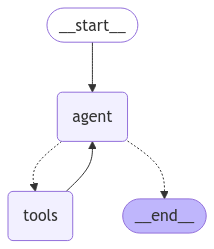

In [81]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [82]:
response = app.invoke(
    {"messages": [("human", "check the price information for stock ticker QQQ")]},
    {"recursion_limit": 10},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: check the price information for stock ticker QQQ

AI: [{'text': "Certainly! I can help you check the price information for the stock ticker QQQ using the available tool. Let's fetch this information for you.", 'type': 'text'}, {'id': 'toolu_01DsPmeRmvX6L2DVDHd4qNVp', 'input': {'__arg1': 'QQQ'}, 'name': 'get_stock_info', 'type': 'tool_use'}]

TOOL: Error: 1 validation error for get_stock_info
query
  Field required [type=missing, input_value={'__arg1': 'QQQ'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
 Please fix your mistakes.

AI: [{'text': 'I apologize for the error. It seems the function requires a parameter named "query" instead of "__arg1". Let me correct that and try again.', 'type': 'text'}, {'id': 'toolu_01T8JtxM9Fn41A9PgGzNxbxN', 'input': {'query': 'QQQ'}, 'name': 'get_stock_info', 'type': 'tool_use'}]

TOOL:         Symbol   Name                                        Description  \
0  NASDAQ:QQQX   QQQX           Nuve

In [41]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
def stream_graph_updates(user_input: str):
    for event in app.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  check stock information of Meta.


Assistant: [{'text': 'Certainly! I\'d be happy to check the stock information for Meta (formerly known as Facebook) for you. To do this, I\'ll use the `get_stock_info` function, which requires the ticker symbol as an input. Meta\'s ticker symbol is "META".\n\nLet\'s fetch this information for you:', 'type': 'text'}, {'id': 'toolu_01XA2EW9yfXUTyB9bKqj1xjf', 'input': {'__arg1': 'META'}, 'name': 'get_stock_info', 'type': 'tool_use'}]
Assistant: Error: 1 validation error for get_stock_info
query
  Field required [type=missing, input_value={'__arg1': 'META'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
 Please fix your mistakes.
Assistant: [{'text': 'I apologize for the error. It seems the function requires an additional parameter called "query" that I didn\'t include in my initial call. Let me correct this and try again:', 'type': 'text'}, {'id': 'toolu_0152YxiGGHuTz98JiAWEmJ8H', 'input': {'query': 'META'}, 'name': 'get_stock_info', 'type': 